## **Imports**

In [1]:
import math
import numpy as np
import torch
import os
from os.path import join as pjoin
import random
import matplotlib
import pandas as pd
import csv

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, FFMpegFileWriter
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import mpl_toolkits.mplot3d.axes3d as p3

## **Visualize Function**

In [2]:
kinematic_chain = [[0, 2, 5, 8, 11], 
                       [0, 1, 4, 7, 10], 
                       [0, 3, 6, 9, 12, 15], 
                       [9, 14, 17, 19, 21], 
                       [9, 13, 16, 18, 20]]

def plot_3d_motion(save_path, kinematic_tree, mp_joints, title, figsize=(10, 10), fps=120, radius=4):

    title_sp = title.split(' ')
    if len(title_sp) > 20:
        title = '\n'.join([' '.join(title_sp[:10]), ' '.join(title_sp[10:20]), ' '.join(title_sp[20:])])
    elif len(title_sp) > 10:
        title = '\n'.join([' '.join(title_sp[:10]), ' '.join(title_sp[10:])])

    def init():
        ax.set_xlim3d([-radius / 4, radius / 4])
        ax.set_ylim3d([0, radius / 2])
        ax.set_zlim3d([0, radius / 2])
        fig.suptitle(title, fontsize=20)
        ax.grid(b=False)

    def plot_xzPlane(minx, maxx, miny, minz, maxz):
        ## Plot a plane XZ
        verts = [
            [minx, miny, minz],
            [minx, miny, maxz],
            [maxx, miny, maxz],
            [maxx, miny, minz]
        ]
        xz_plane = Poly3DCollection([verts])
        xz_plane.set_facecolor((0.5, 0.5, 0.5, 0.5))
        ax.add_collection3d(xz_plane)

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')
    init()

    mp_data = []
    frame_number = min([data.shape[0] for data in mp_joints])

    colors = ['red', 'green', 'black', 'red', 'blue',
              'darkblue', 'darkblue', 'darkblue', 'darkblue', 'darkblue',
              'darkred', 'darkred', 'darkred', 'darkred', 'darkred']

    mp_offset = list(range(-len(mp_joints)//2, len(mp_joints)//2, 1))
    mp_colors = [[colors[i]] * 15 for i in range(len(mp_offset))]

    for i,joints in enumerate(mp_joints):

        # (seq_len, joints_num, 3)
        data = joints.copy().reshape(len(joints), -1, 3)

        MINS = data.min(axis=0).min(axis=0)
        MAXS = data.max(axis=0).max(axis=0)

        height_offset = MINS[1]
        data[:, :, 1] -= height_offset

        mp_data.append({"joints":data,
                        "MINS":MINS,
                        "MAXS":MAXS,})

    def update(index):
        for line in ax.lines:
            line.remove()
        for collection in ax.collections:
            collection.remove()
        ax.view_init(elev=120, azim=-90)
        # plot_xzPlane(-3, 3, 0, -3, 3)
        for pid,data in enumerate(mp_data):
            for i, (chain, color) in enumerate(zip(kinematic_tree, mp_colors[pid])):
                if i < 5:
                    linewidth = 4.0
                else:
                    linewidth = 2.0
                ax.plot3D(data["joints"][index, chain, 0], data["joints"][index, chain, 1], data["joints"][index, chain, 2], linewidth=linewidth,
                          color=color)

        ax.set_axis_off()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        
    ani = FuncAnimation(fig, update, frames=frame_number, interval=1000 / fps, repeat=False)
    ani.save(save_path, fps=fps)
    plt.close()
    
    print('done ! animation saved to {}'.format(save_path))

In [3]:
## data directory
data_root = './data/'
motion_dir = pjoin(data_root, 'motions')
text_dir = pjoin(data_root, 'texts')

## pick a random file
fname = random.choice(os.listdir(motion_dir))

## load motion & text
motion = np.load(pjoin(motion_dir, fname))
print('motion shape:', motion.shape)
with open(pjoin(text_dir, fname.replace('.npy', '.txt'))) as fr:
    texts = fr.read().strip().split('\n')
    
print('Number of text descriptions:', len(texts))
## pick a random text for visualization
title = random.choice(texts)
print('title:', title)

motion shape: (14, 384)
Number of text descriptions: 3
title: the first person touches the right upper arm of the second with the left hand.


In [11]:
J_pos = 22
pos_dim = J_pos * 3          # 66
half = motion.shape[1] // 2  # 192

p1_pos = slice(0, pos_dim)
p2_pos = slice(half, half + pos_dim)

def translate_xz(motion, dx, dz):
    m = motion.copy()
    t = np.array([dx, 0.0, dz], dtype=m.dtype)

    m[:, p1_pos] = (m[:, p1_pos].reshape(-1, J_pos, 3) + t).reshape(-1, pos_dim)
    m[:, p2_pos] = (m[:, p2_pos].reshape(-1, J_pos, 3) + t).reshape(-1, pos_dim)
    return m

motion_1  = translate_xz(motion, dx=1.0, dz=0.0)
motion_2  = translate_xz(motion, dx=0.0, dz=1.0)
motion_xz = translate_xz(motion, dx=1.0, dz=1.0)


In [13]:
J_pos = 22
pos_dim = J_pos * 3          # 66
half = motion.shape[1] // 2  # 192

p1_pos = slice(0, pos_dim)
p2_pos = slice(half, half + pos_dim)

def rotate_y(motion, theta_rad):
    """
    Rotate ALL joint positions of both persons around the y-axis by angle theta_rad.
    Only positions are rotated (x,z). Rotations (6D) are untouched.
    """
    m = motion.copy()
    c, s = np.cos(theta_rad), np.sin(theta_rad)

    def _rot_block(block):
        p = block.reshape(-1, J_pos, 3)      # (T,22,3)
        x = p[..., 0].copy()
        z = p[..., 2].copy()
        p[..., 0] = c * x - s * z            # x'
        p[..., 2] = s * x + c * z            # z'
        return p.reshape(-1, pos_dim)

    m[:, p1_pos] = _rot_block(m[:, p1_pos])
    m[:, p2_pos] = _rot_block(m[:, p2_pos])
    return m

# examples to visualize
motion_1 = rotate_y(motion, theta_rad=np.deg2rad(30.0))
motion_2 = rotate_y(motion, theta_rad=np.deg2rad(90.0))
# motion_r3 = rotate_y(motion, theta_rad=np.deg2rad(-30.0))


In [14]:
## extract positions for both persons
pos_person_1    = motion[:,   p1_pos]
pos_person_2    = motion[:,   p2_pos]
pos_person_1_t1 = motion_1[:, p1_pos]
pos_person_2_t1 = motion_1[:, p2_pos]
pos_person_1_t2 = motion_2[:, p1_pos]
pos_person_2_t2 = motion_2[:, p2_pos]


## save animation
plot_3d_motion('./gif/animation.gif', kinematic_chain, [pos_person_1, pos_person_2], title, radius=4.0, fps=30)
plot_3d_motion('./gif/animation_1.gif', kinematic_chain, [pos_person_1_t1, pos_person_2_t1], title, radius=4.0, fps=30)
plot_3d_motion('./gif/animation_2.gif', kinematic_chain, [pos_person_1_t2, pos_person_2_t2], title, radius=4.0, fps=30)

done ! animation saved to ./gif/animation.gif
done ! animation saved to ./gif/animation_1.gif
done ! animation saved to ./gif/animation_2.gif


## **Evaluation Function**

In [31]:
def eval_recall(gt_df, pred_df, verbose=False):

    ks = list(range(1, 11))  # Recall@1 ... Recall@9

    rank_cols = list(pred_df.columns)

    ## convert to numpy
    gt = gt_df["candidate"].values
    preds = pred_df[rank_cols].values

    assert len(gt) == len(preds), "size mismatch"
    
    ## compute Recall@K
    recalls = {k: 0 for k in ks}
    n = len(gt)

    for i in range(n):
        for k in ks:
            if gt[i] in preds[i, :k]:
                recalls[k] += 1

    for k in ks:
        recalls[k] /= n

    ## weighted aggregation
    weights = {k: 1.0 / k for k in ks} # higher weight for smaller k
    weight_sum = sum(weights.values())

    final_score = sum(
        weights[k] * recalls[k] for k in ks
    ) / weight_sum
    
    if verbose:
        for k, val in recalls.items():
            print('recall@{} = {}'.format(k, round(val, 3)))

    return final_score

## **Generate Validation Batches**

In [32]:
def generate_val_batches(data_root, save_dir, batch_size, num_batches):
    
    os.makedirs(save_dir, exist_ok=True)

    with open(os.path.join(data_root, 'train.txt')) as fd:
        train_fnames = fd.read().strip().split('\n') 

    random_fnames = random.sample(train_fnames, k=batch_size * num_batches)
    random_batches = np.array(random_fnames).reshape(num_batches, batch_size)

    gt = [['query_id', 'candidate']]
    for file_idx, batch in enumerate(random_batches, start=1):
        os.makedirs(pjoin(save_dir, str(file_idx)), exist_ok=True)

        rdm_idx = random.randint(0, len(batch)-1)
        random_text_fname = batch[rdm_idx]

        with open(os.path.join(data_root, 'texts', random_text_fname+'.txt')) as fd:
            file_texts = fd.read().strip().split('\n')
            random_text = random.choice(file_texts)

        with open(os.path.join(save_dir, str(file_idx), 'text.txt'), 'w') as fw:
            fw.write(random_text)

        for motion_idx, fname in enumerate(batch, start=1):
            if fname == random_text_fname:
                gt.append([file_idx, motion_idx])

            motion = np.load(os.path.join(data_root, 'motions', fname+'.npy'))

            np.save(pjoin(save_dir, str(file_idx), 'motion_{}.npy'.format(motion_idx)), motion)


    with open(os.path.join(save_dir, 'gt.csv'), 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(gt)
        
    print('Done ! val batches saved at {} !'.format(save_dir))

In [33]:
## data dir
data_root = './data/'

## dir to save batches to
save_dir = './data/val/'
    
## number of val batches & number of element per batch
batch_size = 32
num_batches = 30

## generate val batches
generate_val_batches(data_root, save_dir, batch_size, num_batches)

Done ! val batches saved at ./data/val/ !


### **Evaluate random submission**

In [34]:
## generate random submission (30 queries × 10 candidates)
random_sub = np.array([
    np.random.choice(range(1, 33), size=10, replace=False)
    for _ in range(30)
])

## create DataFrame
random_sub_df = pd.DataFrame(
    random_sub,
    index=np.arange(1, 31),
    columns=[f'candidate_{i}' for i in range(1, 11)]
)

random_sub_df.index.name = 'query_id'
random_sub_df.head()

,candidate_1,candidate_2,candidate_3,candidate_4,candidate_5,candidate_6,candidate_7,candidate_8,candidate_9,candidate_10
query_id,,,,,,,,,,
1,27,10,7,6,17,11,2,23,21,24
2,8,21,17,24,12,28,25,23,29,30
3,16,26,17,32,12,4,15,23,9,13
4,11,3,21,20,23,9,16,31,24,7
5,18,12,24,5,32,2,17,8,16,1


In [35]:
## load gt
gt_df = pd.read_csv(pjoin(save_dir, 'gt.csv'))
gt_df.head()

,query_id,candidate
0,1,9
1,2,4
2,3,5
3,4,9
4,5,6


In [36]:
## evaluate random results
racall = eval_recall(gt_df, random_sub_df, verbose=True)
print('Recall score:', racall)

recall@1 = 0.033
recall@2 = 0.1
recall@3 = 0.133
recall@4 = 0.133
recall@5 = 0.2
recall@6 = 0.233
recall@7 = 0.267
recall@8 = 0.367
recall@9 = 0.367
recall@10 = 0.4
Recall score: 0.138161044122296


# Translation check

file: 4876.npy motion shape: (116, 384)


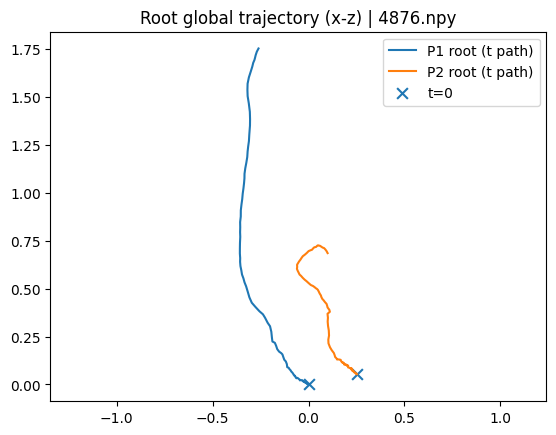

P1 root t=0 (x,z): 0.0 0.0 mean: -0.18903064727783203 0.5187808871269226 std: 0.13020268082618713 0.5672074556350708
P2 root t=0 (x,z): 0.2530798316001892 0.05360299348831177 mean: 0.11143424361944199 0.33625736832618713 std: 0.09430251270532608 0.24769461154937744


In [17]:
from os.path import join as pjoin
import os, random
import numpy as np
import matplotlib.pyplot as plt

# pick a random .npy file (skip subdirectories)
fnames = [f for f in os.listdir(motion_dir) if f.endswith(".npy") and os.path.isfile(pjoin(motion_dir, f))]
fname = random.choice(fnames)
path = pjoin(motion_dir, fname)

motion = np.load(path).astype(np.float32)
print("file:", fname, "motion shape:", motion.shape)

# ---- layout for (T,384) clips ----
J_POS = 22
POS_DIM = J_POS * 3          # 66
HALF = motion.shape[1] // 2  # 192
P1_POS = slice(0, POS_DIM)
P2_POS = slice(HALF, HALF + POS_DIM)

def root_traj_xz(m, person=1, joint=0):
    pos = m[:, P1_POS] if person == 1 else m[:, P2_POS]
    p = pos.reshape(-1, J_POS, 3)
    root = p[:, joint, :]
    return root[:, 0], root[:, 2]  # x(t), z(t)

# plot root trajectory in x-z for both persons
x1, z1 = root_traj_xz(motion, person=1)
x2, z2 = root_traj_xz(motion, person=2)

plt.figure()
plt.plot(x1, z1, label="P1 root (t path)")
plt.plot(x2, z2, label="P2 root (t path)")
plt.scatter([x1[0], x2[0]], [z1[0], z2[0]], marker="x", s=60, label="t=0")
plt.axis("equal")
plt.legend()
plt.title(f"Root global trajectory (x-z) | {fname}")
plt.show()

print("P1 root t=0 (x,z):", float(x1[0]), float(z1[0]), "mean:", float(x1.mean()), float(z1.mean()), "std:", float(x1.std()), float(z1.std()))
print("P2 root t=0 (x,z):", float(x2[0]), float(z2[0]), "mean:", float(x2.mean()), float(z2.mean()), "std:", float(x2.std()), float(z2.std()))


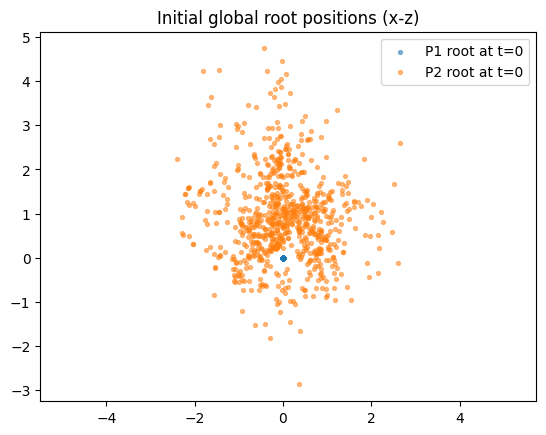

P1 t=0 mean: [0. 0.] std: [0. 0.]
P2 t=0 mean: [-0.0012339  0.9119451] std: [0.8377921 1.0009497]


In [18]:
def sample_initial_root_xz(motion_dir, n=400, seed=0):
    rng = np.random.default_rng(seed)
    fnames = [f for f in os.listdir(motion_dir) if f.endswith(".npy") and os.path.isfile(pjoin(motion_dir, f))]
    idx = rng.choice(len(fnames), size=min(n, len(fnames)), replace=False)

    p1 = []
    p2 = []
    for i in idx:
        m = np.load(pjoin(motion_dir, fnames[i])).astype(np.float32)
        half = m.shape[1] // 2
        p1_pos = m[:, :POS_DIM].reshape(-1, J_POS, 3)
        p2_pos = m[:, half:half+POS_DIM].reshape(-1, J_POS, 3)
        p1.append([p1_pos[0, 0, 0], p1_pos[0, 0, 2]])  # (x0,z0)
        p2.append([p2_pos[0, 0, 0], p2_pos[0, 0, 2]])
    return np.array(p1), np.array(p2)

p1_0, p2_0 = sample_initial_root_xz(motion_dir, n=800, seed=0)

plt.figure()
plt.scatter(p1_0[:,0], p1_0[:,1], s=8, alpha=0.5, label="P1 root at t=0")
plt.scatter(p2_0[:,0], p2_0[:,1], s=8, alpha=0.5, label="P2 root at t=0")
plt.axis("equal")
plt.legend()
plt.title("Initial global root positions (x-z)")
plt.show()

print("P1 t=0 mean:", p1_0.mean(axis=0), "std:", p1_0.std(axis=0))
print("P2 t=0 mean:", p2_0.mean(axis=0), "std:", p2_0.std(axis=0))


In [19]:
import os
import numpy as np

# assumes: motion_dir, pjoin, and constants J_POS, POS_DIM, P1_POS, P2_POS already defined

def y_stats_for_clip(motion: np.ndarray):
    p1 = motion[:, P1_POS].reshape(-1, J_POS, 3)
    p2 = motion[:, P2_POS].reshape(-1, J_POS, 3)

    y1 = p1[..., 1]  # (T,22)
    y2 = p2[..., 1]

    out = {
        "p1_y_min": float(y1.min()),
        "p1_y_max": float(y1.max()),
        "p1_y_mean": float(y1.mean()),
        "p1_y_std": float(y1.std()),
        "p1_y_std_over_time_mean": float(y1.std(axis=1).mean()),  # per-frame spread across joints

        "p2_y_min": float(y2.min()),
        "p2_y_max": float(y2.max()),
        "p2_y_mean": float(y2.mean()),
        "p2_y_std": float(y2.std()),
        "p2_y_std_over_time_mean": float(y2.std(axis=1).mean()),
    }
    return out

def check_y_constant_dataset(motion_dir, n=400, seed=0):
    rng = np.random.default_rng(seed)
    fnames = [f for f in os.listdir(motion_dir) if f.endswith(".npy") and os.path.isfile(pjoin(motion_dir, f))]
    idx = rng.choice(len(fnames), size=min(n, len(fnames)), replace=False)

    # for "constant over time", look at std across time of the root joint y
    root_y_std_p1 = []
    root_y_std_p2 = []

    # and global y range
    y_min_p1, y_max_p1 = np.inf, -np.inf
    y_min_p2, y_max_p2 = np.inf, -np.inf

    for i in idx:
        m = np.load(pjoin(motion_dir, fnames[i])).astype(np.float32)

        p1 = m[:, P1_POS].reshape(-1, J_POS, 3)
        p2 = m[:, P2_POS].reshape(-1, J_POS, 3)

        y1 = p1[..., 1]
        y2 = p2[..., 1]

        y_min_p1 = min(y_min_p1, float(y1.min()))
        y_max_p1 = max(y_max_p1, float(y1.max()))
        y_min_p2 = min(y_min_p2, float(y2.min()))
        y_max_p2 = max(y_max_p2, float(y2.max()))

        root_y_std_p1.append(float(p1[:, 0, 1].std()))  # std over time of root y
        root_y_std_p2.append(float(p2[:, 0, 1].std()))

    root_y_std_p1 = np.array(root_y_std_p1)
    root_y_std_p2 = np.array(root_y_std_p2)

    print(f"Sampled clips: {len(idx)}")
    print("P1 y global min/max:", y_min_p1, y_max_p1)
    print("P2 y global min/max:", y_min_p2, y_max_p2)
    print("P1 root y std over time: mean", root_y_std_p1.mean(), "max", root_y_std_p1.max())
    print("P2 root y std over time: mean", root_y_std_p2.mean(), "max", root_y_std_p2.max())

# 1) check on current loaded motion
stats = y_stats_for_clip(motion)
stats


{'p1_y_min': 0.0,
 'p1_y_max': 1.35752534866333,
 'p1_y_mean': 0.8072892427444458,
 'p1_y_std': 0.42645400762557983,
 'p1_y_std_over_time_mean': 0.4259471595287323,
 'p2_y_min': 0.0,
 'p2_y_max': 1.3624868392944336,
 'p2_y_mean': 0.8025839924812317,
 'p2_y_std': 0.41918647289276123,
 'p2_y_std_over_time_mean': 0.41842296719551086}

In [20]:
check_y_constant_dataset(motion_dir, n=800, seed=0)


Sampled clips: 800
P1 y global min/max: 0.0 2.173743963241577
P2 y global min/max: 0.0 1.968697428703308
P1 root y std over time: mean 0.0313682640080151 max 0.4204105734825134
P2 root y std over time: mean 0.0316774127716053 max 0.4470379650592804
